In [1]:
import numpy as np
import h5py
import torch
import os
import matplotlib.pyplot as plt

In [2]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

In [3]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSims'
base_path = results_path + current_directory

In [41]:
def load_final_model_performances(cv_results_path, filename, type=None, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            #print(f.keys())
            a_group_key = list(f.keys())
            for key in a_group_key:
                #print(key)
        
                if key=="client_local_test_log":
                    client_keys = list(f[key])
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
    
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                elif key=="global_test_error_log" and "NOFL" not in filename:
                    # Do I need to turn this off for NoFL? Or will it just be empty and append something empty...
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                elif key=="local_test_error_log":
                    # Genuinely have no idea what this is... is it client_local_test_log but already averaged out?? No clue
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                else:
                    pass
            #print()

    # So now that all that is extracted and saved to the dict, iterate through the dict and... average by client?
    client_logs = {f'S{i}_client_local_test_log': [] for i in range(num_clients)}  # S0 to S13
    global_test_log = []
    local_test_log = []
    for fold in range(num_folds):
        for i in range(num_clients):
            # Access client local test logs for each fold
            client_key = f'S{i}_client_local_test_log_fold{fold}'
            try:
                client_data = np.array(extraction_dict[client_key])
                #print(f"{client_key}: {client_data.shape}") --> It doesnt get to here if it fails!
    
                if len(client_logs[f'S{i}_client_local_test_log']) == 0:
                    client_logs[f'S{i}_client_local_test_log'] = client_data
                else:
                    client_logs[f'S{i}_client_local_test_log'] += client_data
                    
                #print(f"{client_key} SUCCESS!")
            except KeyError:
                # It was a testing client and thus not saved, so just skip to the next iter
                #print(f"{client_key} FAILED!")
                pass

        #print(filename)
        if "NOFL" in filename:
            pass
        else: 
            # Access global and local test logs for each fold
            global_key = f'global_test_error_log_fold{fold}'
            #print(extraction_dict.keys())
            global_data = extraction_dict[global_key][:]
            if len(global_test_log) == 0:
                global_test_log = np.array(global_data)
            else:
                global_test_log += np.array(global_data)
        
        local_key = f'local_test_error_log_fold{fold}'
        local_data = extraction_dict[local_key][:]
        if len(local_test_log) == 0:
            local_test_log = np.array(local_data)
        else:
            local_test_log += np.array(local_data)
    
    # Average the client test logs and the global/local test errors
    ## In the cross scenario, it should divide client_logs by 6, not 7, since each client is withheld once
    averaged_client_logs = {client: np.array(client_logs[client]) / num_folds for client in client_logs}
    if "NOFL" in filename:
        averaged_global_test_log = None
    else:    
        averaged_global_test_log = np.array(global_test_log) / num_folds
    averaged_local_test_log = np.array(local_test_log) / num_folds
    
    # Return the results
    return averaged_client_logs, averaged_global_test_log, averaged_local_test_log


# Sims Results Plot

In [170]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSims'
base_path = results_path + current_directory

# CROSS
cpfa_avg_cli_logs, cpfa_avg_glo_tst_log, cpfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold', type="CROSS")
cfa_avg_cli_logs, cfa_avg_glo_tst_log, cfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-25_FEDAVG', 'GDLS_FEDAVG_KFold', type="CROSS")
cnofl_avg_cli_logs, _, cnofl_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-30_NOFL', 'FULLSCIPYMIN_NOFL_KFold', type="CROSS")
# INTRA
ipfa_avg_cli_logs, ipfa_avg_glo_tst_log, ipfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-05_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold', type="INTRA")
ifa_avg_cli_logs, ifa_avg_glo_tst_log, ifa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-04_FEDAVG', 'GDLS_FEDAVG_KFold', type="INTRA")
inofl_avg_cli_logs, _, inofl_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_22-56_NOFL', 'FULLSCIPYMIN_NOFL_KFold', type="INTRA")


In [171]:
keys = list(cpfa_avg_cli_logs.keys())
keys

['S0_client_local_test_log',
 'S1_client_local_test_log',
 'S2_client_local_test_log',
 'S3_client_local_test_log',
 'S4_client_local_test_log',
 'S5_client_local_test_log',
 'S6_client_local_test_log',
 'S7_client_local_test_log',
 'S8_client_local_test_log',
 'S9_client_local_test_log',
 'S10_client_local_test_log',
 'S11_client_local_test_log',
 'S12_client_local_test_log',
 'S13_client_local_test_log']

In [172]:
cpfa_avg_cli_dict = {i: value for i, value in enumerate(cpfa_avg_cli_logs.values())}
cfa_avg_cli_dict = {i: value for i, value in enumerate(cfa_avg_cli_logs.values())}
cnofl_avg_cli_dict = {i: value for i, value in enumerate(cnofl_avg_cli_logs.values())}
ipfa_avg_cli_dict = {i: value for i, value in enumerate(ipfa_avg_cli_logs.values())}
ifa_avg_cli_dict = {i: value for i, value in enumerate(ifa_avg_cli_logs.values())}
inofl_avg_cli_dict = {i: value for i, value in enumerate(inofl_avg_cli_logs.values())}


In [173]:
def mean_of_last_n(values, n=10):
    return np.mean(values[-n:])

# Create lists by calculating the mean of the last 10 values
cpfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cpfa_avg_cli_logs.values()]
cfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cfa_avg_cli_logs.values()]
cnofl_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cnofl_avg_cli_logs.values()]
ipfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in ipfa_avg_cli_logs.values()]
ifa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in ifa_avg_cli_logs.values()]
inofl_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in inofl_avg_cli_logs.values()]


In [174]:
inofl_avg_cli_lst

[1.1333130999467099e-06,
 1.3238447333338317e-06,
 7.707713509172294e-07,
 1.348189332332271e-06,
 1.1211532913911374e-06,
 7.423655174816078e-07,
 6.65638785747948e-07,
 1.0537339687917913e-06,
 4.778083428939015e-07,
 9.96157949158905e-07,
 8.79757827888439e-07,
 8.872193781093957e-07,
 4.0692453245539416e-07,
 4.620277913358508e-07]

In [175]:
#cli_fold_log_lst = 
INTRA_cli_fold_log_lst = [inofl_avg_cli_dict, ifa_avg_cli_dict, ipfa_avg_cli_dict]
CROSS_cli_fold_log_lst = [cnofl_avg_cli_dict, cfa_avg_cli_dict, cpfa_avg_cli_dict]

INTRA_finalavg_cli_fold_log_lst = [inofl_avg_cli_lst, ifa_avg_cli_lst, ipfa_avg_cli_lst]
CROSS_finalavg_cli_fold_log_lst = [cnofl_avg_cli_lst, cfa_avg_cli_lst, cpfa_avg_cli_lst]

all_trials_lst = [inofl_avg_cli_lst, ifa_avg_cli_lst, ipfa_avg_cli_lst, cnofl_avg_cli_lst, cfa_avg_cli_lst, cpfa_avg_cli_lst]

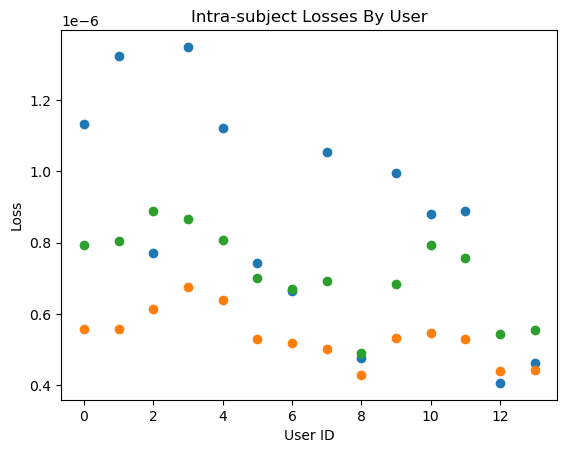

In [176]:
for cli_fold_log in INTRA_finalavg_cli_fold_log_lst:
    plt.scatter(range(len(cli_fold_log)), cli_fold_log)
plt.title("Intra-subject Losses By User")
plt.ylabel('Loss')
plt.xlabel('User ID')
plt.show()

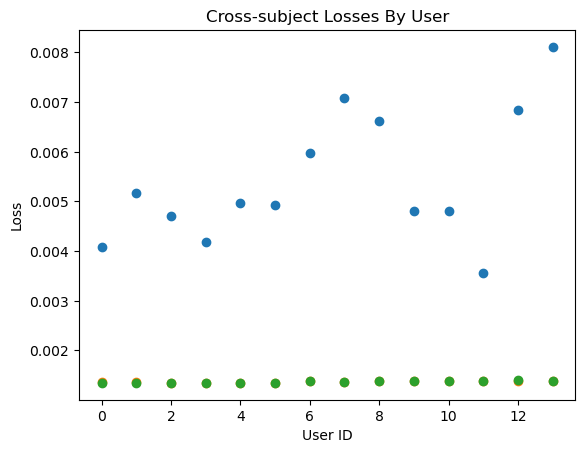

In [177]:
for cli_fold_log in CROSS_finalavg_cli_fold_log_lst:
    plt.scatter(range(len(cli_fold_log)), cli_fold_log)
plt.title("Cross-subject Losses By User")
plt.ylabel('Loss')
plt.xlabel('User ID')
plt.show()

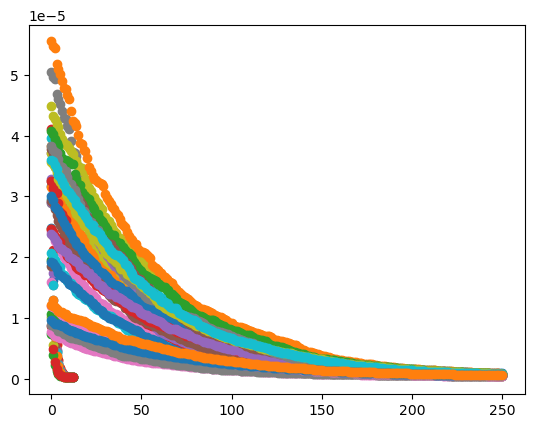

In [178]:
for cli_idx, cli_fold_log in enumerate(INTRA_cli_fold_log_lst):
    for cli_idx in range(NUM_CLIENTS):
        plt.scatter(range(len(cli_fold_log[cli_idx])), cli_fold_log[cli_idx])

In [179]:
#plt.scatter(range(len(cross_pfa)), cross_pfa, label="Cross PFA")
#plt.scatter(range(len(cross_fedavg)), cross_fedavg, label="Cross FedAvg")
#plt.scatter(range(len(cross_nofl)), cross_nofl, label="Cross NoFL")
#plt.legend()
#plt.xlabel("Client ID?")
#plt.ylabel("Simulation Test Loss")
#plt.title("")
#plt.show()

In [180]:
#all_trials_lst = [intra_nofl, intra_fedavg, intra_pfa1, cross_nofl, cross_fedavg, cross_pfa]

In [181]:
INTRA_YLIM_UPPERBOUND = 1.5e-6
CROSS_YLIM_LOWERBOUND = 0.00028
CROSS_YLIM_UPPERBOUND = 0.0085

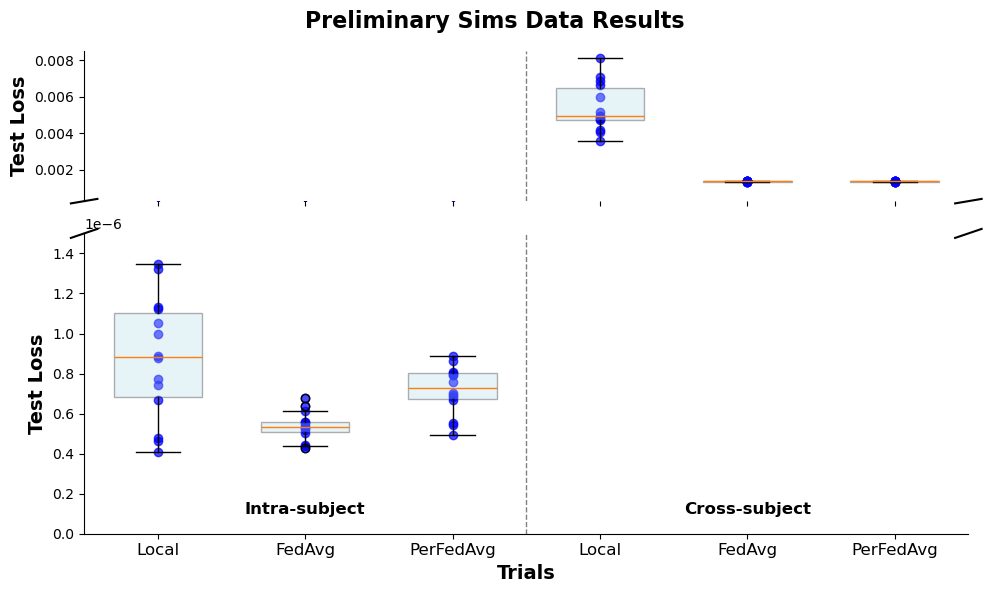

In [182]:
# Set up the figure and two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# Define x-tick labels and corresponding subgroup labels
x_labels = ['Local', 'FedAvg', 'PerFedAvg', 'Local', 'FedAvg', 'PerFedAvg']
subgroup_labels = ['Intra-subject', 'Cross-subject naive', 'Cross-subject\nspecialized']

# Positions for the boxplots
positions = np.arange(len(x_labels))

# Plotting the boxplots for ax1 and ax2 with transparent boxes
boxplot_elements1 = ax1.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)
boxplot_elements2 = ax2.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)

# Set the transparency for the boxes in both subplots
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor('lightblue')  # Set box color
    box.set_alpha(0.3)  # Set transparency (0: fully transparent, 1: fully opaque)

# Plotting the scatter points over the boxplots in both subplots
for i in range(NUM_PLOTTED_CONDITIONS):
    ax1.scatter([i] * NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')
    ax2.scatter([i] * NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')

# Set y-limits for each subplot to create the break
ax1.set_ylim(CROSS_YLIM_LOWERBOUND, CROSS_YLIM_UPPERBOUND)  # High values for CROSS-subject
ax2.set_ylim(0, INTRA_YLIM_UPPERBOUND)  # Low values for INTRA-subject

# Adding the "break" visual indicators
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # Don't show top labels
ax2.xaxis.tick_bottom()  # Only show x labels on the bottom plot

# Diagonal lines indicating the break
d = 0.015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Set the x-tick labels for the bottom plot
ax2.set_xticks(positions)
ax2.set_xticklabels(x_labels, fontsize=12)

# FOR CROSS SUBJECT NAIVE AND SPECIALIZED
# Adding vertical lines for separation in both subplots
#for ax in [ax1, ax2]:
#    ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
#    ax.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)
## Adding subgroup labels below the x-tick labels with better positioning in the bottom plot
#ax2.text(1, 1e-7, 'Intra-subject', ha='center', fontsize=12, weight='bold')
#ax2.text(3.5, 1e-7, 'Cross-subject naive', ha='center', fontsize=12, weight='bold')
#ax2.text(5, 1e-7, 'Cross-subject\nspecialized', ha='center', fontsize=12, weight='bold')

# Adding vertical lines for separation in both subplots
for ax in [ax1, ax2]:
    ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
# Adding subgroup labels below the x-tick labels with better positioning in the bottom plot
ax2.text(1, 1e-7, 'Intra-subject', ha='center', fontsize=12, weight='bold')
ax2.text(4, 1e-7, 'Cross-subject', ha='center', fontsize=12, weight='bold')

# Axis labels and title
ax1.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax2.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax2.set_xlabel("Trials", fontsize=14, fontweight='bold')
fig.suptitle("Preliminary Sims Data Results", fontsize=16, fontweight='bold')

# Remove top and right plot borders from both subplots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [186]:
# VALUES TO NOT SHOW LOCAL CROSS SUBJECT IN ORDER TO ZOOM ON FA AND PFA
#INTRA_YLIM_UPPERBOUND = 1.5e-6
#CROSS_YLIM_LOWERBOUND = 0.0013
#CROSS_YLIM_UPPERBOUND = 0.00143

## Adding Global Models

In [193]:
cpfa_final_global_loss = mean_of_last_n(cpfa_avg_glo_tst_log)
cfa_final_global_loss = mean_of_last_n(cfa_avg_glo_tst_log)
ipfa_final_global_loss = mean_of_last_n(ipfa_avg_glo_tst_log)
ifa_final_global_loss = mean_of_last_n(ifa_avg_glo_tst_log)


In [194]:
print(f"cpfa_final_global_loss: {cpfa_final_global_loss}")
print(f"cfa_final_global_loss: {cfa_final_global_loss}")
print(f"ipfa_final_global_loss: {ipfa_final_global_loss}")
print(f"ifa_final_global_loss: {ifa_final_global_loss}")

cpfa_final_global_loss: 0.0015942996455851697
cfa_final_global_loss: 0.001596315203530286
ipfa_final_global_loss: 7.43501161601078e-07
ifa_final_global_loss: 5.524318974783417e-07


In [203]:
INTRA_YLIM_UPPERBOUND = 1.5e-6
CROSS_YLIM_LOWERBOUND = 0.0010
CROSS_YLIM_UPPERBOUND = 0.0085

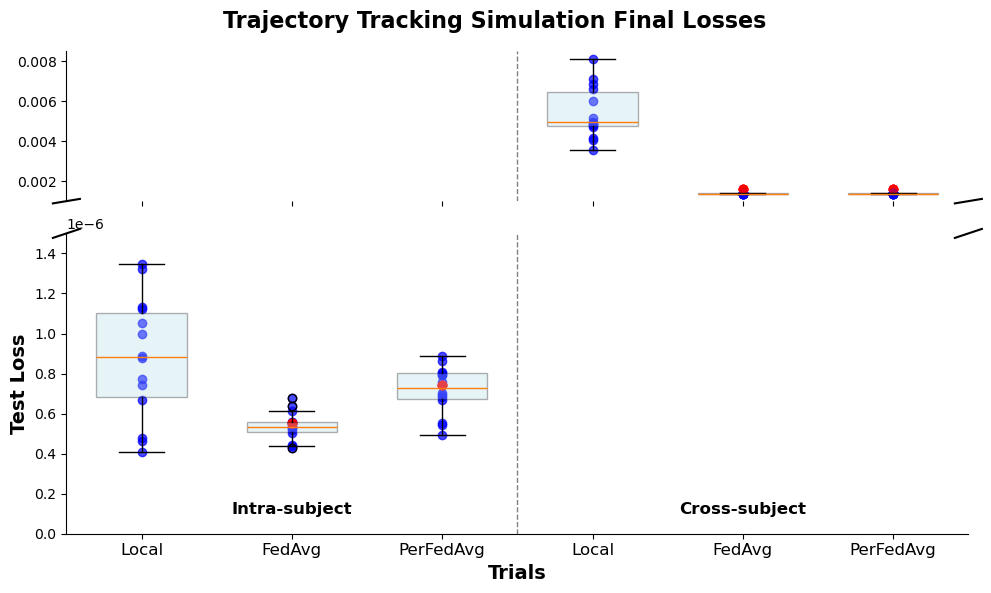

In [208]:
# Set up the figure and two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 2]})

# Define x-tick labels and corresponding subgroup labels
x_labels = ['Local', 'FedAvg', 'PerFedAvg', 'Local', 'FedAvg', 'PerFedAvg']
subgroup_labels = ['Intra-subject', 'Cross-subject naive', 'Cross-subject\nspecialized']

# Positions for the boxplots
positions = np.arange(len(x_labels))

# Plotting the boxplots for ax1 and ax2 with transparent boxes
boxplot_elements1 = ax1.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)
boxplot_elements2 = ax2.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)

# Set the transparency for the boxes in both subplots
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor('lightblue')  # Set box color
    box.set_alpha(0.3)  # Set transparency (0: fully transparent, 1: fully opaque)

# Plotting the scatter points over the boxplots in both subplots
for i in range(NUM_PLOTTED_CONDITIONS):
    ax1.scatter([i] * NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')
    ax2.scatter([i] * NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')

    # Not sure if this is where these belong or not... do I have to plot them on both axes... idk
    ax1.scatter(5, cpfa_final_global_loss, alpha=0.7, color='red')
    ax1.scatter(4, cfa_final_global_loss, alpha=0.7, color='red')
    ax1.scatter(2, ipfa_final_global_loss, alpha=0.7, color='red')
    ax1.scatter(1, ifa_final_global_loss, alpha=0.7, color='red')

    ax2.scatter(5, cpfa_final_global_loss, alpha=0.7, color='red')
    ax2.scatter(4, cfa_final_global_loss, alpha=0.7, color='red')
    ax2.scatter(2, ipfa_final_global_loss, alpha=0.7, color='red')
    ax2.scatter(1, ifa_final_global_loss, alpha=0.7, color='red')

# Set y-limits for each subplot to create the break
ax1.set_ylim(CROSS_YLIM_LOWERBOUND, CROSS_YLIM_UPPERBOUND)  # High values for CROSS-subject
ax2.set_ylim(0, INTRA_YLIM_UPPERBOUND)  # Low values for INTRA-subject

# Adding the "break" visual indicators
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # Don't show top labels
ax2.xaxis.tick_bottom()  # Only show x labels on the bottom plot

# Diagonal lines indicating the break
d = 0.015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Set the x-tick labels for the bottom plot
ax2.set_xticks(positions)
ax2.set_xticklabels(x_labels, fontsize=12)

# FOR CROSS SUBJECT NAIVE AND SPECIALIZED
# Adding vertical lines for separation in both subplots
#for ax in [ax1, ax2]:
#    ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
#    ax.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)
## Adding subgroup labels below the x-tick labels with better positioning in the bottom plot
#ax2.text(1, 1e-7, 'Intra-subject', ha='center', fontsize=12, weight='bold')
#ax2.text(3.5, 1e-7, 'Cross-subject naive', ha='center', fontsize=12, weight='bold')
#ax2.text(5, 1e-7, 'Cross-subject\nspecialized', ha='center', fontsize=12, weight='bold')

# Adding vertical lines for separation in both subplots
for ax in [ax1, ax2]:
    ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
# Adding subgroup labels below the x-tick labels with better positioning in the bottom plot
ax2.text(1, 1e-7, 'Intra-subject', ha='center', fontsize=12, weight='bold')
ax2.text(4, 1e-7, 'Cross-subject', ha='center', fontsize=12, weight='bold')

# Axis labels and title
#ax1.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax2.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax2.set_xlabel("Trials", fontsize=14, fontweight='bold')
fig.suptitle("Trajectory Tracking Simulation Final Losses", fontsize=16, fontweight='bold')

# Remove top and right plot borders from both subplots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

# Tight layout for better spacing
plt.tight_layout()

plt.savefig('SimsResults.jpg')

# Show the plot
plt.show()
